In [9]:
%matplotlib inline

from memsql.common import connection_pool
from scipy import stats
import sys, signal, argparse
import matplotlib
import matplotlib.pyplot as plt
import bestLib
import os

### Define your connection variables for MemSQL here

In [10]:
DB_HOST = os.environ.get("MEMSQL_PORT_3306_TCP_ADDR") # Your MemSQL host
DB_PORT = 3306
DB_USER = "root"
DB_PASS = None
DB_NAME = "stocks"

pool = connection_pool.ConnectionPool()
db_args = [DB_HOST, DB_PORT, DB_USER, DB_PASS, DB_NAME]

### The ticker symbols we want to analyze

In [11]:
TICKERS = [
    'BLAH', 'DUH', 'UM', 'UHH', 'ERR',
    'WUT', 'LOL', 'DERP', 'UP', 'DOWN'
]

### Plot the ask and bid quotes for the tickers

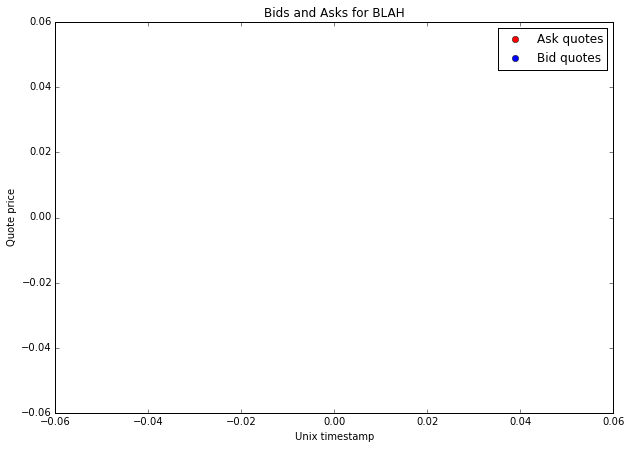

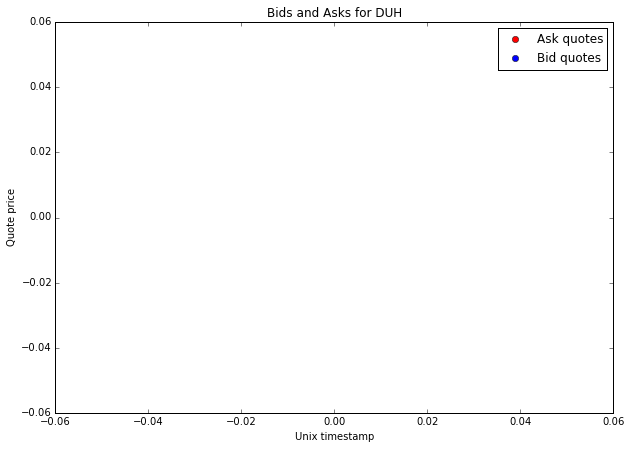

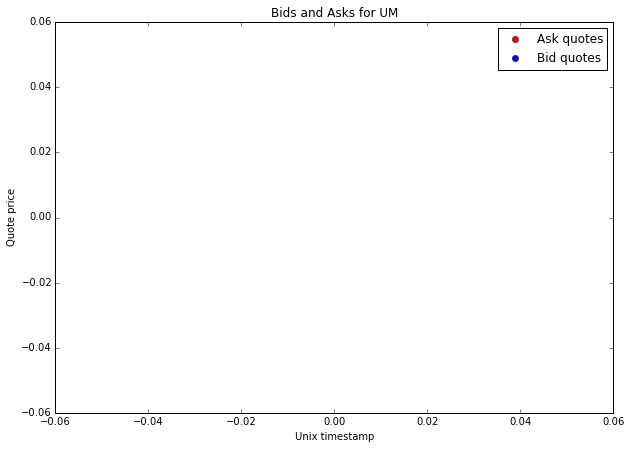

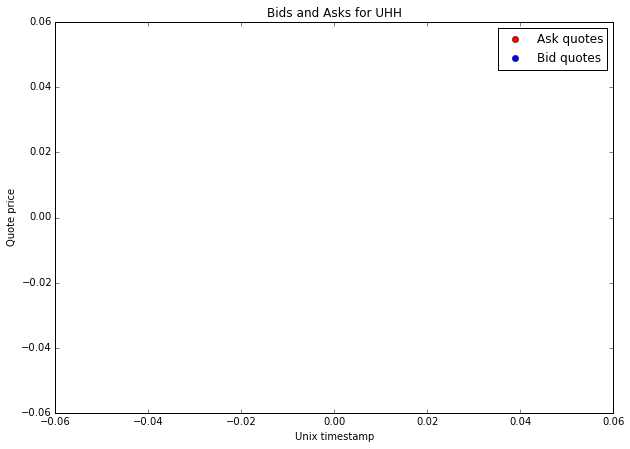

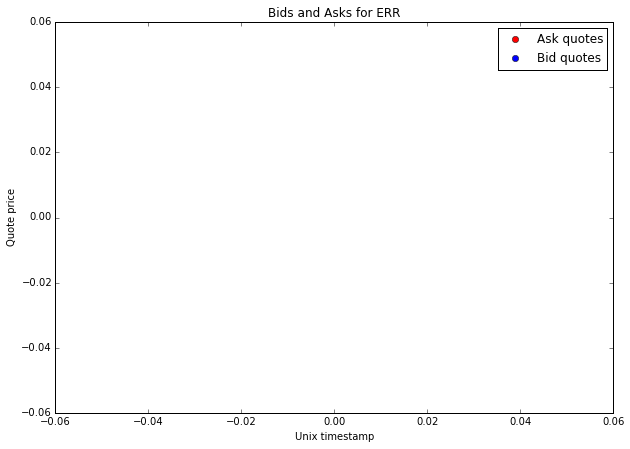

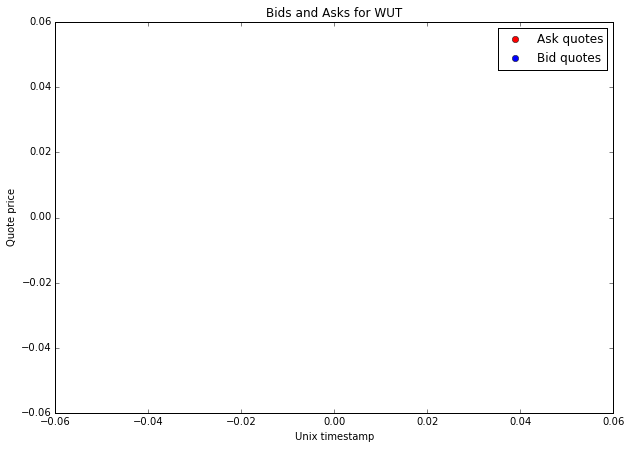

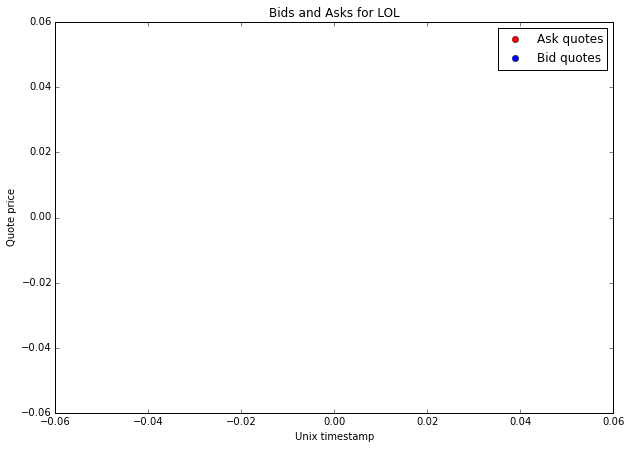

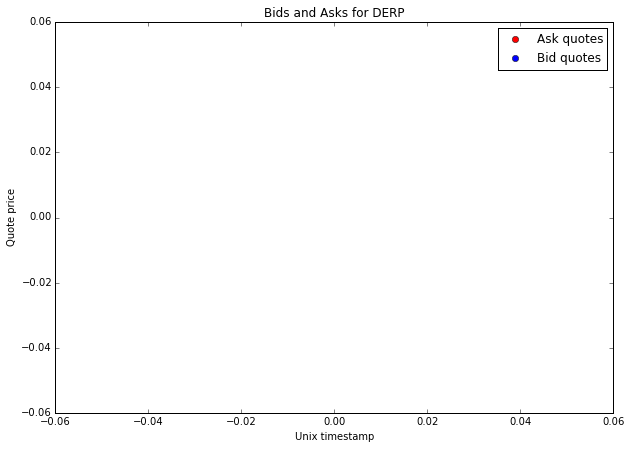

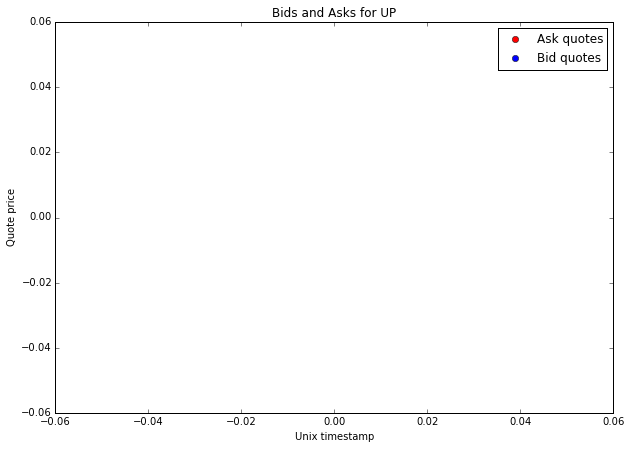

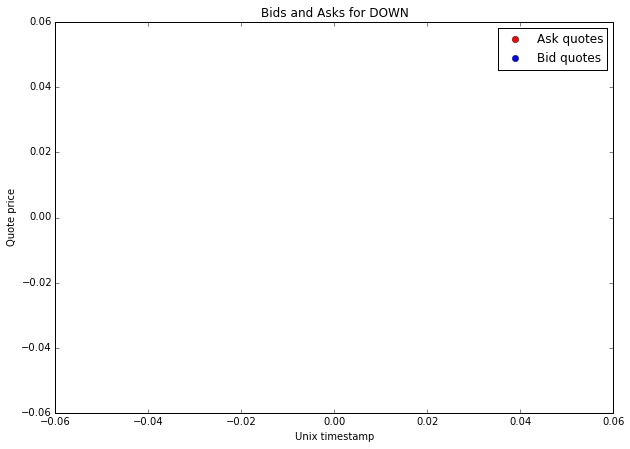

In [12]:
for ticker in TICKERS:
    with pool.connect(*db_args) as c:
        asks_query = "SELECT * FROM ask_quotes WHERE ticker='%s';" % ticker
        bids_query = "SELECT * FROM bid_quotes WHERE ticker='%s';" % ticker

        a = c.query(asks_query)
        tsa = [getattr(i, 'ts') for i in a]
        apa = [getattr(i, 'ask_price') for i in a]

        b = c.query(bids_query)
        tsb = [getattr(i, 'ts') for i in b]
        apb = [getattr(i, 'bid_price') for i in b]

        plt.figure(figsize=(10,7))
        plt.plot(tsa, apa, 'ro', label='Ask quotes')
        plt.plot(tsb, apb, 'bo', label='Bid quotes')
        plt.title('Bids and Asks for %s' % ticker)
        plt.ylabel("Quote price")
        plt.xlabel("Unix timestamp")
        plt.legend(numpoints=1)
        
        plt.show()

### Select the best asks and bids for a given ticker

In [5]:
bestLib.get_best("LOL", pool.connect(*db_args))


BEST ASKS (OVERALL)
ticker	ask_price	ask_size	exchange	timestamp
LOL	4993	99	NASDAQ	144658409073265

LOL	4993	99	NYS	144658409084194

LOL	4993	98	NASDAQ	144658409091815

LOL	4993	98	FRA	144658409080329

LOL	4993	98	FRA	144658409099453

LOL	4993	97	NASDAQ	144658409091805

LOL	4993	97	FRA	144658409099221

LOL	4993	96	LON	144658409069598

LOL	4993	96	NYS	144658409084055

LOL	4993	96	NYS	144658409084174


BEST ASKS (PER EXCHANGE)
ticker	ask_price	ask_size	exchange	timestamp
LOL	4993	99	NYS	144658409084194

LOL	4993	98	FRA	144658409080329

LOL	4993	96	TYO	144658409076757

LOL	4993	99	NASDAQ	144658409073265

LOL	4993	96	LON	144658409069598


BEST BIDS (OVERALL)
ticker	bid_price	bid_size	exchange	timestamp
LOL	5004	98	NYS	144658407502302

LOL	5004	98	NASDAQ	144658407493849

LOL	5004	97	FRA	144658407499486

LOL	5004	95	FRA	144658407499561

LOL	5004	95	TYO	144658407496652

LOL	5004	95	TYO	144658407496610

LOL	5004	94	NYS	144658407502347

LOL	5004	91	FRA	144658407499505

LOL	5004	90	TYO	1446584

### Run linear regression on the ask prices

In [6]:
import time

def regress(ticker):
    unsuccessful_tries = 0
    successful_tries = 0
    
    while True:
        with pool.connect(*db_args) as c:
            a = c.query('''
                SELECT ask_price, ts
                FROM (
                    SELECT *
                    FROM ask_quotes
                    ORDER BY ts DESC LIMIT 10000) window
                JOIN (
                    SELECT AVG(ask_price) avg_ask
                    FROM ask_quotes WHERE ticker = "{0}") avg
                JOIN (
                        SELECT STD(ask_price) std_ask
                        FROM ask_quotes
                        WHERE ticker = "{0}") std
                WHERE ticker="{0}"
                    AND abs(ask_price - avg.avg_ask) < (std.std_ask);
            '''.format(ticker))

            x = [a[i]['ts'] for i in range(len(a) - 1)]
            y = [a[i]['ask_price'] for i in range(len(a) - 1)]
            
        if len(a) > 0:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            print '\nTicker: %s' % "LOL"
            print 'Time: %s' % time.time()
            print 'Slope: %s' % slope
            print 'R squared: %s' % r_value ** 2
            print 'Standard error: %s' % std_err
            print '\n-------------------------------'
            successful_tries += 1
            if successful_tries > 100:
                break
        else:
            unsuccessful_tries += 1
            if (unsuccessful_tries > 9):
                print "Too many unsuccessful tries. Make sure gen.py is running. Exiting."
                sys.exit(0)
                
regress("LOL")


Ticker: LOL
Time: 1446606077.03
Slope: -6.26372959462e-07
R squared: 3.262302019e-05
Standard error: 5.75586397386e-06

-------------------------------

Ticker: LOL
Time: 1446606077.23
Slope: -6.26372959462e-07
R squared: 3.262302019e-05
Standard error: 5.75586397386e-06

-------------------------------

Ticker: LOL
Time: 1446606077.37
Slope: -6.26372959462e-07
R squared: 3.262302019e-05
Standard error: 5.75586397386e-06

-------------------------------

Ticker: LOL
Time: 1446606077.51
Slope: -6.26372959462e-07
R squared: 3.262302019e-05
Standard error: 5.75586397386e-06

-------------------------------

Ticker: LOL
Time: 1446606077.65
Slope: -6.26372959462e-07
R squared: 3.262302019e-05
Standard error: 5.75586397386e-06

-------------------------------

Ticker: LOL
Time: 1446606077.79
Slope: -6.26372959462e-07
R squared: 3.262302019e-05
Standard error: 5.75586397386e-06

-------------------------------

Ticker: LOL
Time: 1446606077.92
Slope: -6.26372959462e-07
R squared: 3.262302019e